In [ ]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text
from textblob import TextBlob
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

## Creating Word Clouds for speeches from 5 significant years
### 1946: End of WW2, 1976: End of Vietnam war, 1990: End of the cold war, 2002: Following 9/11, 2009: Global fin.crisis

In [ ]:
data = pd.read_pickle('pickled_data/data_first_clean.pkl')
data.drop(['President', 'Party','speech', 'first_clean_tokenized'], axis=1, inplace = True)
data = data.rename({'first_clean' : 'speech'}, axis=1)
#Significant years: 1946, end of ww2, 1976 end of Vietnam war, 1990 end of cold war, 2002 9/11, 2009 glob fin crisis
years = [1946, 1976, 1990, 2002, 2009]

data = data.loc[data['year'].isin(years)]
data = data.reset_index(drop=True)

data['year'] = data.year.astype('str')
data.head()

In [ ]:
speech_dict = dict(zip(data.year, data.speech))

In [ ]:
stop_words = text.ENGLISH_STOP_WORDS

wc = WordCloud(stopwords=stop_words, background_color="black", colormap="Dark2",
               max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [10, 6]


for key, value in speech_dict.items():
    wc.generate(value)
    
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(key)    
    plt.show()

### Sentiment analysis of the 5 years, using TextBlob

In [ ]:
def sentiment(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None

In [ ]:
data.head()

In [ ]:
data['polarity'] = data.speech.apply(sentiment).apply(lambda x: x[0])
data['subjectivity'] = data['speech'].apply(sentiment).apply(lambda x: x[1])

In [ ]:
data

## As an experiment, we try the prelearned model from: https://huggingface.co/MoritzLaurer/policy-distilbert-7d on the same 5 years

In [ ]:
def ml_policy(text):
    model_name = "MoritzLaurer/policy-distilbert-7d"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    input = tokenizer(text, truncation=True, return_tensors="pt")

    output = model(input["input_ids"])
    prediction = torch.softmax(output["logits"][0], -1).tolist()

    label_names = ["external relations", "freedom and democracy",
               "political system", "economy", "welfare and quality of life",
               "fabric of society", "social groups"]
    prediction = {name: round(float(pred) * 100, 1) for pred, name in
              zip(prediction, label_names)}
    return prediction

In [ ]:
for x, y in speech_dict.items():
    print('Year: ', x)
    print(ml_policy(y))

In [99]:
first_speech = list(range(1901, 2022, 4))


<class 'list'>
1901
1905
1909
1913
1917
1921
1925
1929
1933
1937
1941
1945
1949
1953
1957
1961
1965
1969
1973
1977
1981
1985
1989
1993
1997
2001
2005
2009
2013
2017
2021


In [105]:
data2 = pd.read_pickle('pickled_data/data_first_clean.pkl')
data2.head()

,year,President,Party,speech,first_clean,first_clean_tokenized
0,1900,William McKinley,Republican,To the Senate and House of Representatives: \n...,to the senate and house of representatives: at...,"[senate, house, representatives, outgoing, old..."
1,1901,Theodore Roosevelt,Republican,To the Senate and House of Representatives: \n...,to the senate and house of representatives: th...,"[senate, house, representatives, congress, ass..."
2,1902,Theodore Roosevelt,Republican,To the Senate and House of Representatives: \n...,to the senate and house of representatives: we...,"[senate, house, representatives, still, contin..."
3,1903,Theodore Roosevelt,Republican,To the Senate and House of Representatives: \n...,to the senate and house of representatives: th...,"[senate, house, representatives, country, cong..."
4,1904,Theodore Roosevelt,Republican,To the Senate and House of Representatives: \n...,to the senate and house of representatives: th...,"[senate, house, representatives, nation, conti..."


In [106]:
def sentiment(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None

In [107]:
data2['polarity'] = data2['first_clean'].apply(sentiment).apply(lambda x: x[0])
data2['subjectivity'] = data2['first_clean'].apply(sentiment).apply(lambda x: x[1])

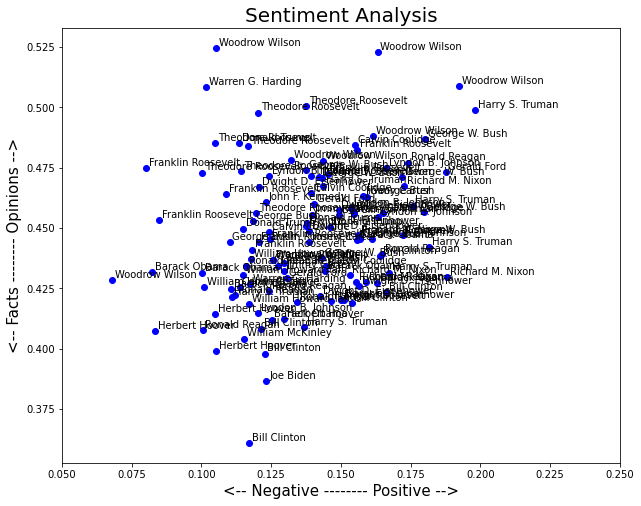

In [110]:
plt.rcParams['figure.figsize'] = [10, 8]

for index, president in enumerate(data2.index):
    x = data2.polarity.loc[president]
    y = data2.subjectivity.loc[president]
    plt.scatter(x, y, color='blue')
    plt.text(x+.001, y+.001, data2['President'][index], fontsize=10)
    plt.xlim(.05, .25)
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

In [112]:
df_csv = pd.read_csv('data/gdp.csv')
df_csv.rename(columns={'date': 'year', 'change-chained' : 'GDP'}, inplace=True)

gdp = df_csv.iloc[:, [0, 4]]

gdp.sort_values(by=['year'], inplace=True)
print(gdp.head())

   year   GDP
0  1930  -6.4
1  1931 -12.9
2  1932  -1.3
3  1933  10.8
4  1934   8.9


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
